In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

import gymnasium as gym
#gymnasium is a fork of gym, that is kept updated

from IPython.display import Image, display
import matplotlib.pyplot as plt
import imageio

from functions import *
from train import *

This code is designed to solve the Pendulum Upright Swing reinforcement learning (RL) problem. It is a continuous control tasks from Gymnasium package. In this environment, the agent controls a pendulum suspended from one end and attempts to balance it upright by applying torques at its pivot. The pendulum starts from a random initial angle, and the goal is to swing it up so that it stays in the upright position with minimal effort.

<div style="display: flex; gap: 20px;">
    <div style="text-align: center;">
        <strong>Trained Actions</strong><br>
        <img src="Trained_Actions.gif" alt="Trained Actions" style="width:45%;">
    </div>
    <div style="text-align: center;">
        <strong>Random Actions</strong><br>
        <img src="RandomActions.gif" alt="Random Actions" style="width:45%;">
    </div>
</div>

## Setup the gym environment. 
#### print the size of the State space, Action space, and Action Value range

In [2]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print(f"State Space Size = {num_states}: [x, y, theta-dot]")
print(f"Action Space Size = {num_actions}: Torque")
print(f"{lower_bound} <= Torque <= {upper_bound}")

State Space Size = 3: [x, y, theta-dot]
Action Space Size = 1: Torque
-2.0 <= Torque <= 2.0


## Visiualize the initial state, with random actions

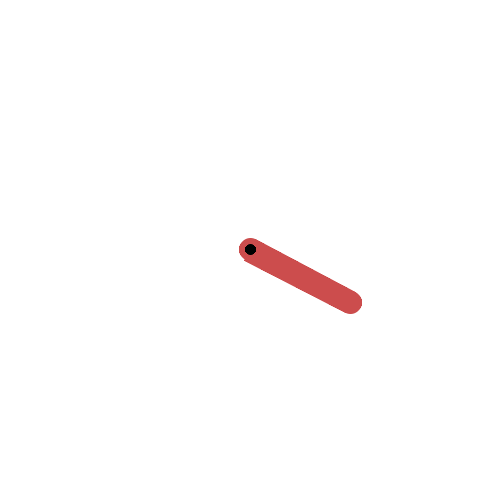

In [3]:
obs, info = env.reset()
frames = []

for _ in range(100):
    frames.append(env.render())
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break

imageio.mimsave('RandomActions.gif', frames, fps=30, loop=0)
display(Image(filename='RandomActions.gif'))

In [4]:


# Slightly smaller actor_lr encourages stable policy improvement
actor_lr = 0.001
# Slightly larger critic_lr allows the critic to adapt faster to policy changes
critic_lr = 0.002
gamma = 0.99
tau = 0.005
total_episodes = 200

# The actor outputs continuous actions scaled by upper_bound (torque)
actor_model = build_actor(num_states, num_actions, upper_bound)
target_actor = build_actor(num_states, num_actions, upper_bound)

# The critic approximates Q-values for (state, action) pairs
critic_model = build_critic(num_states, num_actions)
target_critic = build_critic(num_states, num_actions)

# Align target networks with main networks at the start
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# buffer encapsulates the DDPG training logic and the replay buffer
buffer = DDPG(
    actor_model,
    critic_model,
    target_actor,
    target_critic,
    num_states,
    num_actions,
    gamma,
    tau,
    buffer_capacity=50000,
    batch_size=64,
    critic_lr=critic_lr,
    actor_lr=actor_lr
)

# Store rewards and episodes
ep_rewards = []
avg_rewards = []
episode_rewards = []
average_rewards = []

## Reward
### $ r = - \theta^2 + 0.1*\dot{\theta}^2 + 0.001*\tau^2$

with $\theta$ as the angle between the pendulum and the upright position, and $\tau$ is the applied Torque. From the gym env.

In [5]:
# Noise to promote exploration
noise = GaussianActionNoise(mean=np.zeros(1), std_deviation=0.1 * np.ones(1))

for ep in range(total_episodes):
    prev_state, _ = env.reset()
    episodic_reward = 0

    while True:
        tf_prev_state = tf.expand_dims(
            tf.convert_to_tensor(prev_state), 0
        )

        action = policy(tf_prev_state, noise,actor_model)
        # Receive state and reward from environment.
        state, reward, done, truncated, _ = env.step(action)

        buffer.record((prev_state, action, reward, state)) #tuple
        episodic_reward += reward

        buffer.learn()

        update_target(target_actor, actor_model, tau)
        update_target(target_critic, critic_model, tau)

        # End this episode when `done` or `truncated` is True
        if done or truncated:
            break

        prev_state = state

    ep_rewards.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_rewards[-40:])
    print(f"Episode {ep}  <Reward> = {avg_reward}")
    avg_rewards.append(avg_reward)

Episode 0  <Reward> = -1035.5273752125445
Episode 1  <Reward> = -900.2558672991362
Episode 2  <Reward> = -1203.8474795562315
Episode 3  <Reward> = -1329.388869368576
Episode 4  <Reward> = -1283.2000790245854
Episode 5  <Reward> = -1352.9158004898886
Episode 6  <Reward> = -1373.628457055689
Episode 7  <Reward> = -1391.2680108214688
Episode 8  <Reward> = -1397.0548535496534
Episode 9  <Reward> = -1376.2330654610598
Episode 10  <Reward> = -1345.8550201253827
Episode 11  <Reward> = -1312.8253879328358
Episode 12  <Reward> = -1280.9310130045856
Episode 13  <Reward> = -1249.5939084186336
Episode 14  <Reward> = -1217.0597394700135
Episode 15  <Reward> = -1188.8724437674332
Episode 16  <Reward> = -1157.1183980784435
Episode 17  <Reward> = -1121.0856978767024
Episode 18  <Reward> = -1062.4778789487054
Episode 19  <Reward> = -1029.092855351315
Episode 20  <Reward> = -991.4042414066263
Episode 21  <Reward> = -952.0158193294154
Episode 22  <Reward> = -921.4076975006336
Episode 23  <Reward> = -883.

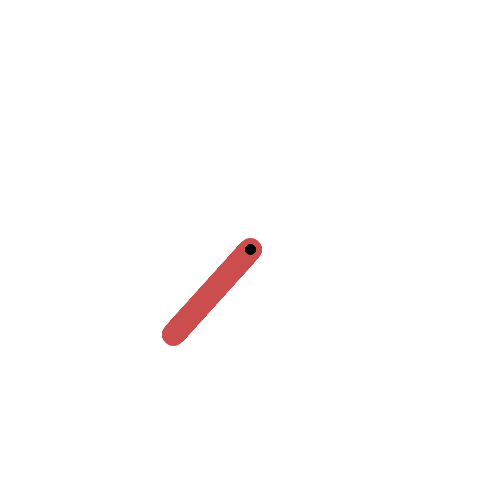

In [6]:
from IPython.display import HTML

frames = []
state, _ = env.reset()
state = np.expand_dims(state, axis=0)
for _ in range(100):  # Number of steps to simulate
    # Render the environment and collect the frame
    frame = env.render()
    frames.append(frame)
    
    action = actor_model.predict(state, verbose=0)  # Replace with your model's predict function
    action = action[0] 

    next_state, reward, done, truncated, info = env.step(action)
    state = np.expand_dims(next_state, axis=0)  # Update state

imageio.mimsave('Trained_Actions.gif', frames, fps=30,loop=0) 
display(Image(filename='Trained_Actions.gif'))

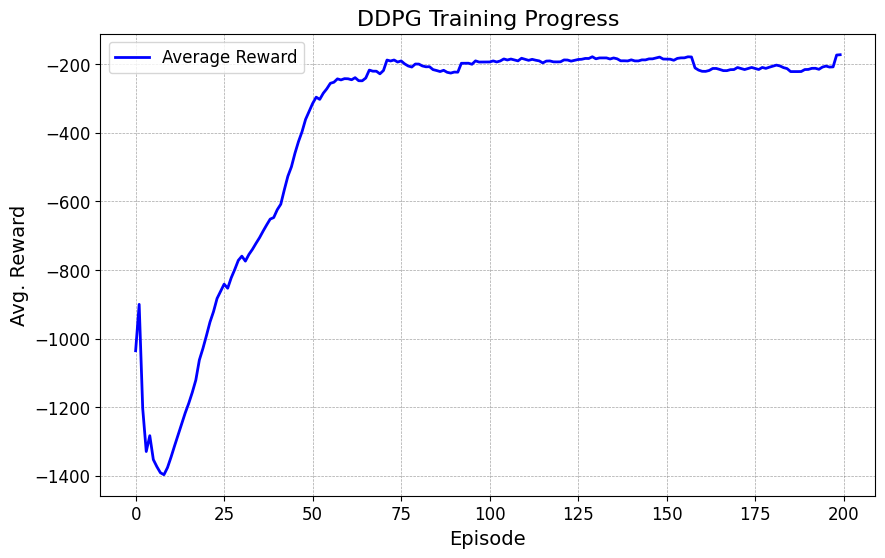

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(avg_rewards, color='blue', linewidth=2, label="Average Reward")
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.title("DDPG Training Progress", fontsize=16)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Avg. Reward", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()